In [1]:
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import igraph
import h5py
from pathlib import Path
from tqdm import tqdm
tqdm.pandas()
from rdkit import Chem
from pandarallel import pandarallel
import msml.utils.data as du
import msml.utils.spectra as su
import msml.utils.mols as mu
import msml.utils.io as io
import msml.utils.plots as plots
from msml.definitions import *

In [2]:
atlas_dir = Path('/storage/plzen1/home/romanb/DreaMS_Atlas')
gems_dir = Path('/storage/plzen1/home/romanb/msvn_C/')

In [3]:
lib = du.MSData('/auto/brno2/home/romanb/msml/msml/data/merged/datasets/nist20_mona_clean_merged_spectra_dreams.hdf5')
gems = du.MSData('/storage/plzen1/home/romanb/msvn_C/msvn_C_H1000_KK1.merged.hdf5')
print(lib.num_spectra, gems.num_spectra, lib.num_spectra + gems.num_spectra)
def get_item(i, val=PRECURSOR_MZ):
    if i <= lib.num_spectra:
        return lib.get_values(val, i)
    else:
        res = gems.get_values(val, i - lib.num_spectra)
        if val == SPECTRUM:
            res = res.T
        return res

knn = du.CSRKNN.from_npz(atlas_dir / 'DreaMS_Atlas_3NN_merged40079300_09_pruned.npz')
print(knn.n_nodes, knn.n_edges, knn.k)

df_clusters = pd.read_csv(atlas_dir / 'DreaMS_Atlas_3NN_merged40079300_09_pruned_clusters.csv')

79300 75520646 75599946
33631113 134524452 3


In [4]:
cluster_idx_1 = np.array(io.read_pickle(atlas_dir / 'DreaMS_Atlas_3NN_merged40079300_09_cluster_idx.pkl'))
cluster_idx_2 = np.array(io.read_pickle(atlas_dir / 'DreaMS_Atlas_3NN_merged40079300_09_pruned_cluster_idx.pkl'))
def encode_knn_i(i):
    e1 = np.where(np.array(cluster_idx_1) == i)[0].item()
    e2 = np.where(np.array(cluster_idx_2) == e1)[0].item()
    return e2
def decode_knn_i(i):
    return cluster_idx_1[cluster_idx_2[i]]

In [6]:
g = knn.to_igraph(directed=False)

Constructing graph edges: 100%|██████████| 33631113/33631113 [02:36<00:00, 214858.99it/s]


### Components

In [7]:
components = g.components()
print(len(components))
sorted([len(c) for c in components], reverse=True)[:10]

15733


[33531520, 136, 80, 71, 67, 65, 61, 60, 53, 49]

In [8]:
component1 = components[0]

### Paths to spectral libraries and random subset

In [9]:
pandarallel.initialize(nb_workers=8, progress_bar=True, use_memory_fs=False)
lib_nodes = set(df_clusters['clusters1_and_clusters2'].iloc[:lib.num_spectra].parallel_apply(encode_knn_i).unique())
print(len(lib_nodes))
lib_nodes = lib_nodes.intersection(set(component1))
print(len(lib_nodes))
rand_nodes = set(random.sample(range(g.vcount()), k=len(lib_nodes)))
print(len(rand_nodes))

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [ ]:
def bfs_to_nodes_subset(graph, start_vertex, subset):
    visited = set()
    queue = [(start_vertex, 0)]  # (vertex, distance)
    
    while queue:
        vertex, distance = queue.pop(0)
        visited.add(vertex.index)
        
        # if vertex.index < stop_index:
        #     return distance
        
        if decode_knn_i(vertex.index) in subset:
            return distance, vertex.index

        for neighbor in vertex.neighbors():
            if neighbor.index not in visited:
                queue.append((neighbor, distance + 1))
    
    return -1, -1  # If the stop index is not found within the BFS traversal

# Run BFS with stop condition
start_vertex = g.vs[encode_knn_i(37542683)]
res = bfs_to_nodes_subset(g, start_vertex, lib_nodes)
print(res[0], decode_knn_i(res[1]))

3 34195


In [ ]:
# def shortest_path_len(i, j):
#     return len(g.get_shortest_paths(v=i, to=j, mode='all', output='epath')[0])
# shortest_path_len(encode_knn_i(37542683), encode_knn_i(34195))

In [ ]:
k = 100_000
lib_dists, rand_dists = [], []
for i in tqdm(random.sample(component1, k=k)):
    lib_dists.append(bfs_to_nodes_subset(g, g.vs[i], lib_nodes)[0])
    rand_dists.append(bfs_to_nodes_subset(g, g.vs[i], rand_nodes)[0])

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [56:52<00:00,  2.93it/s]  


In [ ]:
io.write_pickle(lib_dists, 'data/lib_dists.pkl')
io.write_pickle(rand_dists, 'data/rand_dists.pkl')
# lib_dists = io.read_pickle('data/lib_dists.pkl')
# rand_dists = io.read_pickle('data/rand_dists.pkl')

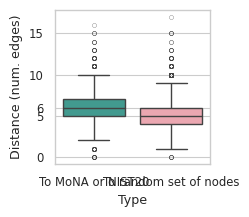

In [15]:
plots.init_plotting(figsize=(2, 2))
palette = [plots.get_nature_hex_colors()[i] for i in [1, 2]]
df_res = pd.DataFrame({'Distance (num. edges)': lib_dists + rand_dists, 'Type': ['To MoNA or NIST20'] * len(lib_dists) + ['To random set of nodes'] * len(rand_dists)})
# sns.histplot(data=df_res, x='Distance', hue='Type', discrete=True, binwidth=1, element="step")
sns.boxplot(data=df_res, y='Distance (num. edges)', hue='Type', x='Type', palette=palette, flierprops={'markersize': 3, 'markeredgewidth': 0.2})
plt.yticks([0, 5, 6, 10, 15])
plots.save_fig('atlas_paths_boxplots.svg', dir=atlas_dir)
plt.show()
# sns.despine(offset=5, trim=True)
# plt.xticks(rotation=45)

### Cluster sizes

In [5]:
f_c = h5py.File(gems_dir / 'msvn_C_H1000.hdf5', 'r')
lshs_c = f_c['lsh'][:]
lshs_c.shape

(201223336,)

In [6]:
lshs_c = pd.Series(lshs_c)
lshs_c_vc = lshs_c.value_counts()
lshs_c_vc = lshs_c_vc.rename('Cluster size')

In [7]:
df_clusters_vc = df_clusters['clusters1_and_clusters2'].value_counts()
df_clusters_vc = df_clusters_vc.rename('Cluster size')

In [9]:
df_clusters_gems = df_clusters.iloc[lib.num_spectra:]
len(df_clusters_gems)

75520646

In [10]:
pandarallel.initialize(nb_workers=8, progress_bar=True, use_memory_fs=False)
df_clusters_gems['lsh'] =  gems.get_values('lsh')[:]
df_clusters_gems['lsh_cluster_size'] = df_clusters_gems['lsh'].parallel_apply(lambda l: lshs_c_vc.loc[l])

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


/tmp/ipykernel_695624/863667647.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clusters_gems['lsh'] =  gems.get_values('lsh')[:]


/tmp/ipykernel_695624/863667647.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clusters_gems['lsh_cluster_size'] = df_clusters_gems['lsh'].parallel_apply(lambda l: lshs_c_vc.loc[l])


In [11]:
df_gems_lsh_gb = df_clusters_gems.groupby(by='clusters1_and_clusters2')['lsh_cluster_size'].sum()
df_gems_lsh_gb

clusters1_and_clusters2
801           1
846          64
882           1
920         126
1010          1
           ... 
75599926      1
75599931     11
75599936      1
75599939      1
75599940      1
Name: lsh_cluster_size, Length: 33564399, dtype: int64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


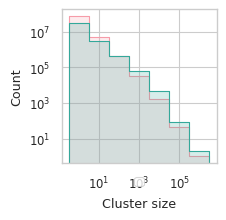

In [20]:
plots.init_plotting(figsize=(2, 2))
df_res = pd.DataFrame({'Cluster size': df_gems_lsh_gb.tolist() + df_clusters_vc.tolist(), 'Type': ['LSH + k-NN clusters'] * len(df_gems_lsh_gb) + ['k-NN clusters'] * len(df_clusters_vc)})
sns.histplot(data=df_res, x='Cluster size', hue='Type', log_scale=True, discrete=True, element='step', alpha=0.2, palette=palette, linewidth=1.5)
plt.yscale('log')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05))
plt.show()

### Edge weights distribution

<Axes: ylabel='Count'>

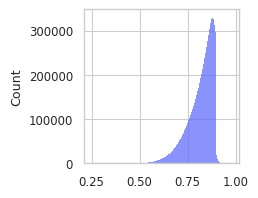

In [5]:
plots.init_plotting(figsize=(2, 2))
w_clustered = knn.csr.data[knn.csr.data > 0]
sns.histplot(w_clustered)

In [7]:
for t in [0.75, 0.8, 0.89, 0.9]:
    print(t, (knn.csr.data > t).sum() / (knn.csr.data > 0).sum())

0.75 0.8433984351130837
0.8 0.6811189956440935
0.89 0.08187227325596932
0.9 0.004390899963184647


In [6]:
knn_full1 = du.CSRKNN.from_npz(atlas_dir / 'DreaMS_Atlas_3NN_before40000000.npz')
knn_full2 = du.CSRKNN.from_npz(atlas_dir / 'DreaMS_Atlas_3NN_after40000000.npz')
w_full = np.concatenate([knn_full1.csr.data[knn_full1.csr.data > 0], knn_full2.csr.data[knn_full2.csr.data > 0]])

In [ ]:
# df_res = pd.DataFrame({'DreaMS similarity': np.concatenate([w_full, w_clustered], 'Type': ['Before clustering'])})
sns.histplot(w_full, color=palette[0], label='Before k-NN clustering')
sns.histplot(w_clustered, color=palette[2], label='After k-NN clustering')
plt.show()